# 本文件说明
- 统计分析
> - 八分类模型数据：噪音与非噪音
> - 补录和预警数据

# 基本设置

In [1]:
import numpy as np
import pandas as pd
import os
import datetime

import requests,json
from sklearn.externals import joblib

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from toolkits.setup.date_time import get_day_list
from toolkits.setup import specific_func
specific_func.set_ch_pd()

## 一些函数

In [3]:
def plot_cor(count_data, day_thing, title):
    fig = plt.figure(figsize = (15,6))
    ax1 = fig.add_subplot(111)
    rects = count_data[['al_cor', 'al_uncor']].plot(kind = 'bar', ax = ax1, alpha=0.5, stacked=True)
    ax1.set_ylabel('num', fontsize = 16)
    ax1.set_title(title, fontsize = 20)
    ax1.legend(['al-cor', 'al-uncor'], loc='upper left')

    ax2 = ax1.twinx()  # this is the important function
    count_data[['al_cor_rate', 'al_uncor_rate']].plot(x = count_data['publishtime'],
                                              kind = 'line', ax = ax2, marker = 'D')
    ax2.set_ylabel('rate', fontsize = 16)
    ax2.set_xlabel('publishtime', fontsize = 16)
    ax2.set_ylim(0, 1)
    ax2.legend(['al-cor-rate', 'al-uncor-rate'], loc='upper center')

    y_list = [0.65, 0.75, 0.85, 0.95]
    m = 0
    for [d, t] in day_thing:    
        if d in count_data['publishtime'].tolist():
            x = count_data['publishtime'].tolist().index(d)
            ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                        color='k', linestyle = "--", alpha = 0.75)
            ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
            if m == 3: 
                m = 0
            else :
                m += 1

    plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
    plt.show()

    print(count_data.sort_values(by = 'publishtime', ascending = False).head())

In [4]:
def plot_tend(tend_count, day_thing, title):
    tend_counts = tend_count.set_index(["tendency", 'publishtime']).unstack('tendency')
    tend_counts.columns = ['neg', 'pos']
    tend_counts['sum'] = tend_counts.sum(axis = 1)
    tend_counts['neg_rate'] =  tend_counts['neg'] / tend_counts['sum']
    tend_counts['pos_rate'] =  tend_counts['pos'] / tend_counts['sum']
    tend_counts = tend_counts.reset_index('publishtime')

    tend_counts = tend_counts.sort_values(by = 'publishtime')
    fig = plt.figure(figsize = (15,6))
    ax1 = fig.add_subplot(111)
    tend_counts[['neg', 'pos']].plot(kind = 'bar', ax = ax1, alpha=0.5, stacked=True)
    ax1.set_ylabel('N', fontsize = 16)
    ax1.set_title(title, fontsize = 20)
    ax1.legend(['neg N', 'pos N'], loc='upper left')

    ax2 = ax1.twinx()  # this is the important function
    tend_counts[['neg_rate', 'pos_rate']].plot(x = tend_counts['publishtime'],
                                             kind = 'line', ax = ax2, marker = 'D')
    ax2.set_ylabel('rate', fontsize = 16)
    ax2.set_xlabel('publishtime', fontsize = 16)
    ax2.set_ylim(0, 1)
    ax2.legend(loc='upper center')
    y_list = [0.65, 0.75, 0.85, 0.95]
    m = 0
    for [d, t] in day_thing:    
        if d in tend_counts['publishtime'].tolist():
            x = tend_counts['publishtime'].tolist().index(d)
            ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                        color='k', linestyle = "--", alpha = 0.75)
            ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
            if m == 3: 
                m = 0
            else :
                m += 1

    plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
    plt.show()

    print(tend_counts.sort_values(by = 'publishtime', ascending = False).head())

In [5]:
def get_server_res(data, url):
    '''
    服务器接口测试程序
    传入 dict, 传出 DataFrame
    '''
    # data = {'record':[{'id':0,'title':'ss','content':'zzz'},]}
    # data = {"record":marked_human_data.iloc[:5,:3].to_dict(orient = 'records')}
    # url "http://47.93.77.19:10000/correlation_negative"
    headers={'content-type':'application/json'}
    result = requests.post(url,
                      data = json.dumps(data),
                      headers=headers, allow_redirects=True)
    # print(result.text)
    json_data = json.loads(result.text)
    parse_data = []
    elapsed_time = json_data['elapsed_time']
    for i in range(len(json_data['docs'])):
        parse_data.append([json_data['docs'][i]['id'],
                          json_data['docs'][i]['cor']])
    parse_data = pd.DataFrame(parse_data, columns = ['id', 'cor'])    
    return parse_data, elapsed_time

In [6]:
def get_server_res_yjh(data, url, col_name):
    '''
    服务器接口测试程序
    传入 dict, 传出 DataFrame
    '''
    # data = {'record':[{'id':0,'title':'ss','content':'zzz'},]}
    # data = {"record":marked_human_data.iloc[:5,:3].to_dict(orient = 'records')}
    # url "http://47.93.77.19:10000/correlation_negative"
    headers={'content-type':'application/json'}
    result = requests.post(url,
                      data = json.dumps(data),
                      headers=headers, allow_redirects=True)
    # print(result.text)
    json_data = json.loads(result.text)
    parse_data = []
#     elapsed_time = json_data['elapsed_time']
    for i in range(len(json_data['docs'])):
        parse_data.append([json_data['docs'][i]['id'],
                          json_data['docs'][i][col_name]])
    parse_data = pd.DataFrame(parse_data, columns = ['id', col_name])    
    return parse_data #, elapsed_time

In [7]:
def get_period_data_for_training(human_additional, warning, url, folder, filename, flag):
    combined_data = pd.concat([human_additional, warning])
    print('去重前', combined_data.shape)
    combined_data = combined_data.drop_duplicates(subset = 'id')
    print('去重后', combined_data.shape)

    # predict
    data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
    if flag == 'circ':
        parse_data, elapsed_time = get_server_res(data, url)
    elif flag == 'cbrc':
        col_name = 'sec'
        parse_data = get_server_res_yjh(data, url, col_name)
        
    print(parse_data.shape)
    # parse_data.head()  

    parse_data.columns = ['id', 'predict_label']
    parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
    parse_data['label'] = ''
    # parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
    # parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
    print(parse_data.shape)
    # parse_data.head()

    combined_data = pd.merge(combined_data, parse_data, on  = 'id')
    print(combined_data.head())

    file_path = '%s/result/%s'%(folder, filename)
    combined_data[['id', 'predict_label', 
                   'label', 'title', 'content']].to_excel(file_path, index = False)

In [8]:
def get_class_data(class_count):
    class_count['c'] = class_count['publishtime'] + class_count['classify']
    class_count.index = range(class_count.shape[0])
    combined_count = {}
    for index in class_count.index:
        c = class_count.loc[index, 'c']
        if c not in combined_count:
            combined_count[c] = {}
            combined_count[c]['count'] = class_count.loc[index, 'count']
        else :
            combined_count[c]['count'] = combined_count[c]['count'] + class_count.loc[index, 'count']

        combined_count[c]['publishtime'] = class_count.loc[index, 'publishtime']
        combined_count[c]['classify'] = class_count.loc[index, 'classify']

    class_count = pd.DataFrame().from_dict(combined_count, orient = 'index')
    class_count.index = range(class_count.shape[0])    

    cor_class = class_count.set_index(['publishtime', 'classify']).unstack()#.reset_index('publishtime')
    cor_class['总量'] = cor_class['count'].sum(axis = 1)
    cor_class_1 = cor_class.copy()
    cor_class_1['非噪音'] = cor_class_1['总量'] - cor_class_1['count', '噪音']
    cor_class_1['非噪音-比例'] = cor_class_1['非噪音'] / cor_class_1['总量']
    cor_class_1['噪音-比例'] = cor_class_1['count', '噪音'] / cor_class_1['总量']
    # cor_class_1.sort_index(ascending = False).head()    
    
    for k in cor_class['count'].columns.tolist():
        cor_class['rate', k] = cor_class['count', k] / cor_class['总量']
#     cor_class.sort_index(ascending = False).head()

    count_data_7 = cor_class_1[['总量',  '非噪音', '非噪音-比例', '噪音-比例']]
    count_data_7.insert(2, '噪音', cor_class_1['count', '噪音'])
    count_data_7.columns = ['sum', 'al_cor', 'al_uncor', 'al_cor_rate', 'al_uncor_rate']
    count_data_7 = count_data_7.reset_index()

    cor_list = ['监管', '行业', '公司内部管理', '消费服务']
    count_data_4 = cor_class_1['count'][cor_list].sum(axis = 1).reset_index()
    ss = cor_class_1.reset_index()
    count_data_4 = pd.merge(count_data_4, ss[['总量', 'publishtime']], on = 'publishtime')
    count_data_4.columns = ['publishtime', 'al_cor', 'sum']
    count_data_4['al_uncor'] = count_data_4['sum'] - count_data_4['al_cor']
    count_data_4['al_cor_rate'] = count_data_4['al_cor'] / count_data_4['sum']
    count_data_4['al_uncor_rate'] = count_data_4['al_uncor'] / count_data_4['sum']

    return cor_class_1, cor_class, count_data_7, count_data_4

# 参数设置

In [9]:
today = datetime.datetime.now()
today_str = today.strftime("%Y-%m-%d")
yesterday = today - datetime.timedelta(days=1)
yesterday_str = yesterday.strftime("%Y-%m-%d")
# data_folder = r'D:\XH\OneDrive\网智天元\4 银保监会\cbirc_获取用于人工判断数据\%s'% yesterday_str
# if not os.path.exists(data_folder):
#     os.makedirs(data_folder)

print('今天是：',today.strftime("%Y-%m-%d"))
print('昨天是：',yesterday_str)
print('统计的是昨天的数据，即 %s 的数据'%yesterday_str)
# print('文件存储位置: ', data_folder)

start_day = today - datetime.timedelta(days=31) # 30 天
start_day = start_day.strftime("%Y-%m-%d") # '2018-08-12'  # 含
end_day = today_str # yesterday_str    # 含
print('start_day：',start_day)
print('end_day：',end_day)

今天是： 2018-11-05
昨天是： 2018-11-04
统计的是昨天的数据，即 2018-11-04 的数据
start_day： 2018-10-05
end_day： 2018-11-05


In [10]:
label_dic={'补录':0,'监管':1,'行业':2,'产品销售':3,'资本市场':4,'公司内部管理':5,'消费服务':6,'其他相关报道':7,'噪音':8}
class_name_dict = {v: k for k, v in label_dic.items()}
class_name_dict

{0: '补录',
 1: '监管',
 2: '行业',
 3: '产品销售',
 4: '资本市场',
 5: '公司内部管理',
 6: '消费服务',
 7: '其他相关报道',
 8: '噪音'}

In [11]:
group = '1-新闻，2-论坛，3-博客，4-微博，5-纸媒，6-视频，7-外媒，8-广播，9-电视，11-微信，13-新闻客户端，15-推特'
group_dict = dict([x.split('-') for x in group.split('，')])
group_dict

{'1': '新闻',
 '11': '微信',
 '13': '新闻客户端',
 '15': '推特',
 '2': '论坛',
 '3': '博客',
 '4': '微博',
 '5': '纸媒',
 '6': '视频',
 '7': '外媒',
 '8': '广播',
 '9': '电视'}

# 保险业--旧

## 特殊时间点

In [12]:
engine = specific_func.get_engine('circ')

In [13]:
circ_day_thing = [['2018-05-31', '上线倾向性模型'], 
             ['2018-06-12', '更新倾向性模型'], 
             ['2018-06-13', '更新倾向性模型'], 
             ['2018-06-15', '更新相关性模型'], 
             ['2018-06-19', '修复bug'], 
             ['2018-06-24', '更新相关性模型'],
             ['2018-06-24', '上线预警模型'], 
             ['2018-06-25', '更新相关性模型（加入交集数据作为噪音）']]

## 八分类

In [14]:
# 相关数据
sql_circ_cor = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.classify, \
                            count(t1.id) as count \
                            from wise_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.classify \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

circ_cor_count = pd.read_sql(sql_circ_cor, engine)
circ_cor_count['classify'] = circ_cor_count['classify'].apply(lambda x:class_name_dict[x])
circ_cor_count.head()

,publishtime,classify,count
0,2018-11-05,补录,1
1,2018-11-05,监管,625
2,2018-11-05,行业,278
3,2018-11-05,产品销售,174
4,2018-11-05,资本市场,2158


In [15]:
# 不相关数据
sql_circ_uncor = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,t1.classify, count(t1.id) as count \
                            from wise_web_docinfo_uncorr t1 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by t1.classify, date_format(t1.publishtime,'%%Y-%%m-%%d') \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

circ_uncor_count = pd.read_sql(sql_circ_uncor, engine)
circ_uncor_count['classify'] = circ_uncor_count['classify'].apply(lambda x:class_name_dict[x])
circ_uncor_count.head()

,publishtime,classify,count
0,2018-11-05,噪音,11327
1,2018-11-04,噪音,36884
2,2018-11-03,噪音,65726
3,2018-11-02,噪音,110372
4,2018-11-01,噪音,113550


### 补录数据

,publishtime,补录
0,2018-11-05,1
8,2018-11-04,2
16,2018-11-03,3
24,2018-11-02,14
32,2018-11-01,11


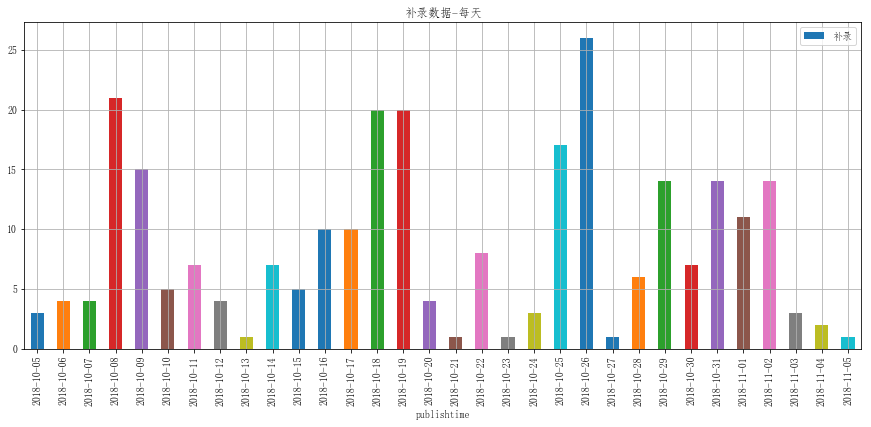

In [16]:
# 补录
apend = circ_cor_count[circ_cor_count['classify'] == '补录'][['publishtime', 'count']]
apend.columns = ['publishtime', '补录']
apend = apend.sort_values(by = 'publishtime', ascending = True)
apend.plot(kind = 'bar', x = 'publishtime', y = '补录', figsize=(15,6), 
           title = '补录数据-每天', grid = True)
apend.sort_values(by = 'publishtime', ascending = False).head()

### class

In [17]:
class_count = pd.concat([circ_cor_count, circ_uncor_count])
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                         总量  \
classify     产品销售 公司内部管理 其他相关报道      噪音  消费服务    监管    行业  补录   资本市场           
publishtime                                                                    
2018-11-05    174    246    157   11327   161   625   278   1   2158   15127   
2018-11-04   1073   1686   1097   36884   569  1737   880   2   2357   46285   
2018-11-03   2124   1142   1372   65726  1197  2042  1664   3   3616   78886   
2018-11-02   2139   2372   1940  110372  2054  4721  2757  14  10281  136650   
2018-11-01   1933   2549   2083  113550  2572  4189  3749  11   8345  138981   

               非噪音 非噪音-比例 噪音-比例  
classify                         
publishtime                      
2018-11-05    3800  0.251 0.749  
2018-11-04    9401  0.203 0.797  
2018-11-03   13160  0.167 0.833  
2018-11-02   26278  0.192 0.808  
2018-11-01   25431  0.183 0.817

count                                                         总量  \
classify     产品销售 公司内部管理 其他相关报道      噪音  消费服务    监管    行业  补录   资本市场           
publishtime                                                                    
2018-11-05    174    246    157   11327   161   625   278   1   2158   15127   
2018-11-04   1073   1686   1097   36884   569  1737   880   2   2357   46285   
2018-11-03   2124   1142   1372   65726  1197  2042  1664   3   3616   78886   
2018-11-02   2139   2372   1940  110372  2054  4721  2757  14  10281  136650   
2018-11-01   1933   2549   2083  113550  2572  4189  3749  11   8345  138981   

             rate                                                    
classify     产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业    补录  资本市场  
publishtime                                                          
2018-11-05  0.012  0.016  0.010 0.749 0.011 0.041 0.018 0.000 0.143  
2018-11-04  0.023  0.036  0.024 0.797 0.012 0.038 0.019 0.000 0.051  
2018-11-03  0.027  0.014  0.017 0.833 0.015 0.026 0.021 0.000 0.046  
2018-11-02  0.016  0.017  0.014 0.808 0.015 0.035 0.020 0.000 0.075  
2018-11-01  0.014  0.018  0.015 0.817 0.019 0.030 0.027 0.000 0.060

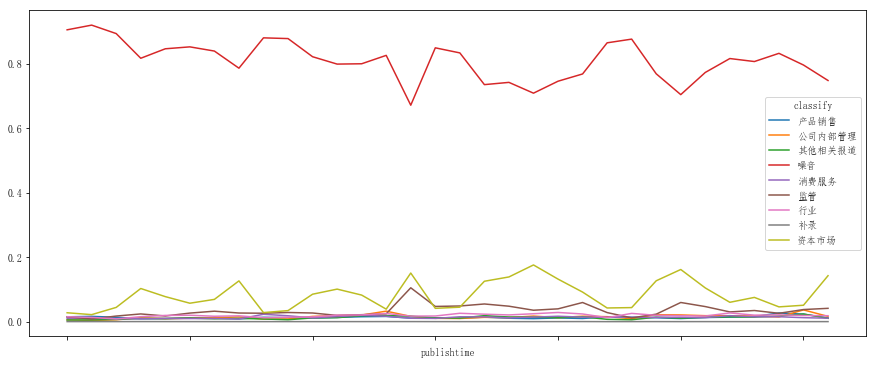

In [18]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

### 总体

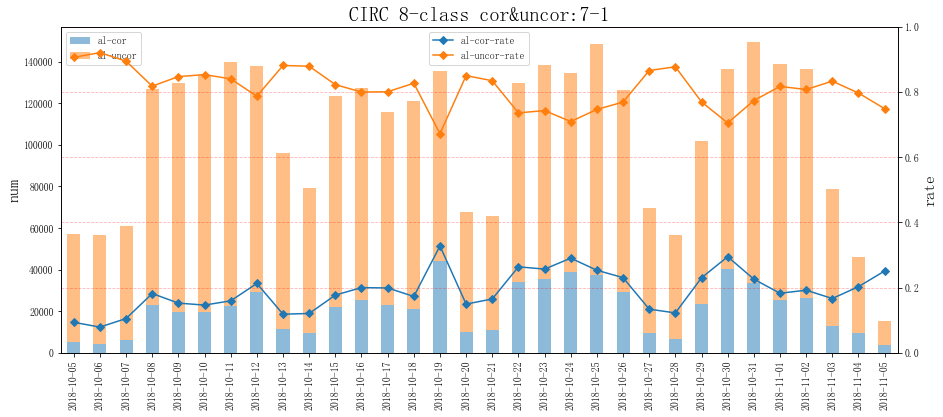

   publishtime     sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
31  2018-11-05   15127    3800     11327        0.251          0.749
30  2018-11-04   46285    9401     36884        0.203          0.797
29  2018-11-03   78886   13160     65726        0.167          0.833
28  2018-11-02  136650   26278    110372        0.192          0.808
27  2018-11-01  138981   25431    113550        0.183          0.817


In [19]:
plot_cor(count_data_7, circ_day_thing, "CIRC 8-class cor&uncor:7-1")

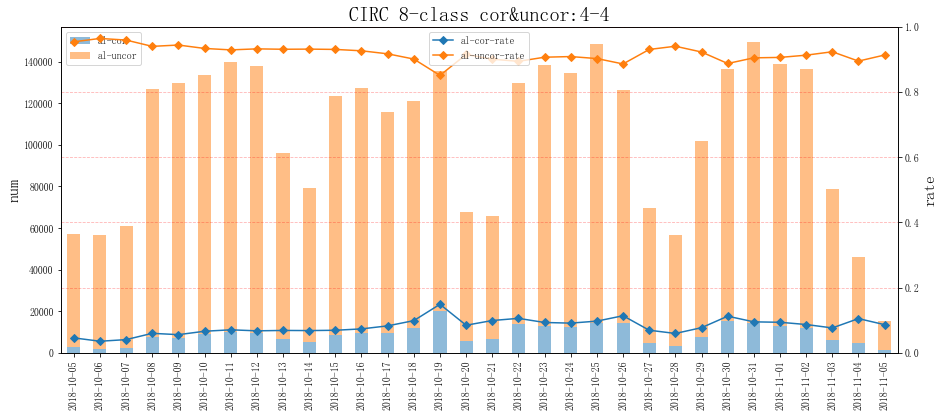

   publishtime  al_cor     sum  al_uncor  al_cor_rate  al_uncor_rate
31  2018-11-05    1310   15127     13817        0.087          0.913
30  2018-11-04    4872   46285     41413        0.105          0.895
29  2018-11-03    6045   78886     72841        0.077          0.923
28  2018-11-02   11904  136650    124746        0.087          0.913
27  2018-11-01   13059  138981    125922        0.094          0.906


In [20]:
plot_cor(count_data_4, circ_day_thing, "CIRC 8-class cor&uncor:4-4")

## 倾向性

In [21]:
sql_tend = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.tendency, \
                            count(t1.id) as count \
                            from wise_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.tendency \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

tend_count = pd.read_sql(sql_tend, engine)
tend_count.head()

,publishtime,tendency,count
0,2018-11-05,-1,288
1,2018-11-05,0,3788
2,2018-11-04,-1,750
3,2018-11-04,0,8657
4,2018-11-03,-1,1086


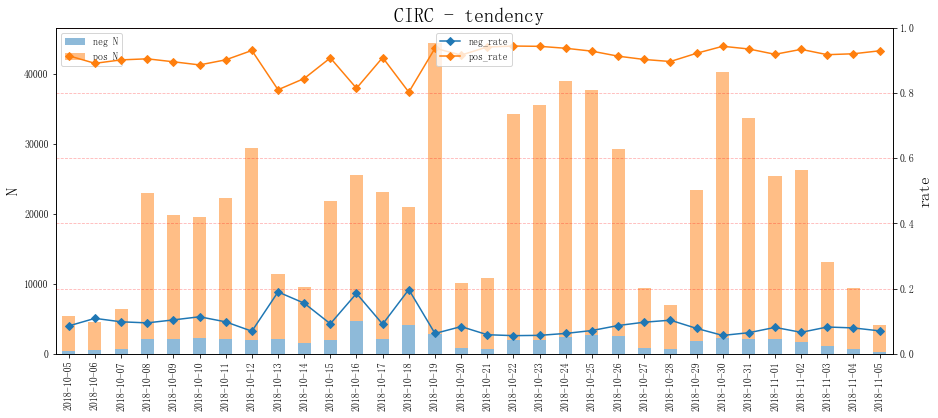

   publishtime   neg    pos    sum  neg_rate  pos_rate
31  2018-11-05   288   3788   4076     0.071     0.929
30  2018-11-04   750   8657   9407     0.080     0.920
29  2018-11-03  1086  12077  13163     0.083     0.917
28  2018-11-02  1740  24540  26280     0.066     0.934
27  2018-11-01  2069  23362  25431     0.081     0.919


In [22]:
plot_tend(tend_count, circ_day_thing, "CIRC - tendency ")

### group_id

In [23]:
# sql_tend_group = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, \
#                             t1.tendency, t1.group_id, count(t1.id) as cor_count \
#                             from wise_web_docinfo t1 \
#                                 where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
#                                       date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
#                                 group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.tendency, t1.group_id \
#                                 order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

# tend_group_count = pd.read_sql(sql_tend_group, engine)
# tend_group_count['group_id'] = tend_group_count['group_id'].apply(lambda x: group_dict[str(x)])
# tend_group_count.head()

## 补录和预警

### 一周数据

In [24]:
add_start_day = '2018-10-27'
add_end_day = '2018-11-02'

In [25]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format(add_start_day, add_end_day) 

human_additional = pd.read_sql(sql_human_additional, engine)
print(human_additional.shape)
# human_additional.head()

(67, 7)


In [26]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.submited = 1 ".format(add_start_day, add_end_day) 

warning = pd.read_sql(sql_warning, engine)
print(warning.shape)
# warning.head()

(124, 7)


In [27]:
combined_data = pd.concat([human_additional, warning])
print('去重前', combined_data.shape)
combined_data = combined_data.drop_duplicates(subset = 'id')
print('去重后', combined_data.shape)

combined_data['group_id'] = combined_data['group_id'].apply(lambda x:group_dict[str(x)])
combined_data['gather_type'] = combined_data['gather_type'].replace(1, '人工补录').replace(2, '人工修改')
combined_data['submited'] = combined_data['submited'].replace(0, '不预警').replace(1, '预警')

去重前 (191, 7)
去重后 (125, 7)


In [28]:
# predict
data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
# url = "http://192.168.0.104:11000/judge_correlation_i"
url = "http://47.93.77.19:10000/judge_correlation_i"
parse_data, elapsed_time = get_server_res(data, url)
# parse_data.head()  

parse_data.columns = ['id', 'predict_label']
parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
parse_data['label'] = ''
parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
parse_data.head()

,id,predict_label,label,cor,all_cor
0,11677278,噪音,,0,0
1,11684462,噪音,,0,0
2,11686197,产品销售,,0,1
3,11686236,噪音,,0,0
4,11686238,消费服务,,1,1


In [29]:
combined_data = pd.merge(combined_data, parse_data, on  = 'id')
stat = combined_data.groupby(['group_id', 'gather_type', 'submited'])['id'].count().reset_index()

# 补录
stat_a = combined_data.groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a = stat_a[stat_a['gather_type'] == '人工补录']

# 补录且预警
stat_a_w = combined_data[combined_data['submited'] == '预警'].groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a_w = stat_a_w[stat_a_w['gather_type'] == '人工补录']

# 预警
stat_w = combined_data.groupby(['group_id', 'submited'])['id'].count().reset_index()
stat_w = stat_w[stat_w['submited'] == '预警']

# 补录-过算法
stat_a_cor = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_cor = stat_a_cor[stat_a_cor['cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_w_cor = stat_a_w_cor[stat_a_w_cor['cor'] == 1]

# 补录-过算法
stat_a_cor_7 = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_cor_7 = stat_a_cor_7[stat_a_cor_7['all_cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor_7 = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_w_cor_7 = stat_a_w_cor_7[stat_a_w_cor_7['all_cor'] == 1]

In [30]:
stat_a = stat_a[['group_id', 'id']]
stat_a.columns = ['来源', '补录']
stat_a_w = stat_a_w[['group_id', 'id']]
stat_a_w.columns = ['来源', '补录且预警']
stat_w = stat_w[['group_id', 'id']]
stat_w.columns = ['来源', '预警数量']
stat_a_cor = stat_a_cor[['group_id', 'id']]
stat_a_cor.columns = ['来源', '补录&过算法(4类)']
stat_a_w_cor = stat_a_w_cor[['group_id', 'id']]
stat_a_w_cor.columns = ['来源', '补录且预警&过算法(4类)']
stat_a_cor_7 = stat_a_cor_7[['group_id', 'id']]
stat_a_cor_7.columns = ['来源', '补录&过算法(7类)']
stat_a_w_cor_7 = stat_a_w_cor_7[['group_id', 'id']]
stat_a_w_cor_7.columns = ['来源', '补录且预警&过算法(7类)']

In [31]:
stat = pd.merge(stat_a, stat_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w, on = '来源', how = 'outer')
# stat = pd.merge(stat, stat_a_cor, on = '来源', how = 'outer')
# stat = pd.merge(stat, stat_a_w_cor, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_cor_7, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w_cor_7, on = '来源', how = 'outer')
stat = stat.set_index('来源').stack().unstack(0)
stat['总量'] =  stat.sum(axis = 1)
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警'] / stat.loc['预警数量'] 
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警 / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警'] / stat.loc['补录'] 
stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警 / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类)'] / stat.loc['补录'] 
# stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类)'] / stat.loc['预警数量'] 
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类) / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类)'] / stat.loc['补录'] 
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类)'] / stat.loc['补录且预警'] 
stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.index.name = '保监会：{0} 到 {1}'.format(add_start_day, add_end_day)
stat

来源,微信,新闻,新闻客户端,纸媒,视频,总量
保监会：2018-10-27 到 2018-11-02,,,,,,
补录,12.000,42.000,2.000,9.000,2.000,67.000
预警数量,12.000,73.000,2.000,35.000,2.000,124.000
补录且预警,12.000,41.000,2.000,9.000,2.000,66.000
补录&过算法(7类),11.000,37.000,2.000,9.000,1.000,60.000
补录且预警&过算法(7类),11.000,36.000,2.000,9.000,1.000,59.000
补录且预警 / 预警-比例,100%,56%,100%,26%,100%,53%
补录且预警 / 补录-比例,100%,98%,100%,100%,100%,99%
补录&过算法(7类) / 补录-比例,92%,88%,100%,100%,50%,90%
补录且预警&过算法(7类) / 补录且预警-比例,92%,88%,100%,100%,50%,89%


### 导出一段时间补录数据用于训练

In [32]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format('2018-08-20', '2018-09-16') 

# human_additional = pd.read_sql(sql_human_additional, engine)
# print(human_additional.shape)
# human_additional.head()

In [33]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.submited = 1 ".format('2018-08-20', '2018-09-16') 

# warning = pd.read_sql(sql_warning, engine)
# print(warning.shape)
# warning.head()

In [34]:
if 0:
    # url = "http://192.168.0.104:11000/judge_correlation_i"
    url = "http://47.93.77.19:10000/judge_correlation_i"
    folder = 'circ_result_class'
    filename = 'circ_add&warning_20180917(0820-0916).xlsx'
    get_period_data_for_training(human_additional, warning, url, folder, filename, 'circ')

# 银行业--旧

## 特殊时间点

In [35]:
engine = specific_func.get_engine('cbrc')

In [36]:
cbrc_day_thing = [['2018-05-02', '相关性模型'], 
             ['2018-06-01', '更新相关性模型'], 
             ['2018-06-12', '更新相关性模型'], 
             ['2018-06-12', '上线倾向性模型']
            ]

## 八分类

In [37]:
sql_cbrc = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, \
                        t2.traffic_id as classify, count(t1.id) as count \
                            from wise_web_docinfo_basic t1, wise_web_classify_traffic_docinfo t2 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t2.base_id=t1.id \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t2.traffic_id \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

cbrc_count = pd.read_sql(sql_cbrc, engine)
cbrc_count['classify'] = cbrc_count['classify'].apply(lambda x:class_name_dict[x])
cbrc_count.head()

,publishtime,classify,count
0,2018-11-05,监管,2033
1,2018-11-05,行业,2364
2,2018-11-05,产品销售,376
3,2018-11-05,资本市场,3912
4,2018-11-05,公司内部管理,526


### class

In [38]:
class_count = cbrc_count
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                        总量  \
classify     产品销售 公司内部管理 其他相关报道      噪音   消费服务     监管     行业   资本市场           
publishtime                                                                   
2018-11-05    376    526    554   12949   1679   2033   2364   3912   24393   
2018-11-04    903   1422   1962   41498   5640   5596   4227   8882   70130   
2018-11-03   2209   2063   3164   66382  11228  12031   6853  13338  117268   
2018-11-02   3585   5520   4656  102952  19458  22249  14696  23704  196820   
2018-11-01   3727   5472   5510  110284  22427  14575  15667  27196  204858   

               非噪音 非噪音-比例 噪音-比例  
classify                         
publishtime                      
2018-11-05   11444  0.469 0.531  
2018-11-04   28632  0.408 0.592  
2018-11-03   50886  0.434 0.566  
2018-11-02   93868  0.477 0.523  
2018-11-01   94574  0.462 0.538

count                                                        总量  \
classify     产品销售 公司内部管理 其他相关报道      噪音   消费服务     监管     行业   资本市场           
publishtime                                                                   
2018-11-05    376    526    554   12949   1679   2033   2364   3912   24393   
2018-11-04    903   1422   1962   41498   5640   5596   4227   8882   70130   
2018-11-03   2209   2063   3164   66382  11228  12031   6853  13338  117268   
2018-11-02   3585   5520   4656  102952  19458  22249  14696  23704  196820   
2018-11-01   3727   5472   5510  110284  22427  14575  15667  27196  204858   

             rate                                              
classify     产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                                    
2018-11-05  0.015  0.022  0.023 0.531 0.069 0.083 0.097 0.160  
2018-11-04  0.013  0.020  0.028 0.592 0.080 0.080 0.060 0.127  
2018-11-03  0.019  0.018  0.027 0.566 0.096 0.103 0.058 0.114  
2018-11-02  0.018  0.028  0.024 0.523 0.099 0.113 0.075 0.120  
2018-11-01  0.018  0.027  0.027 0.538 0.109 0.071 0.076 0.133

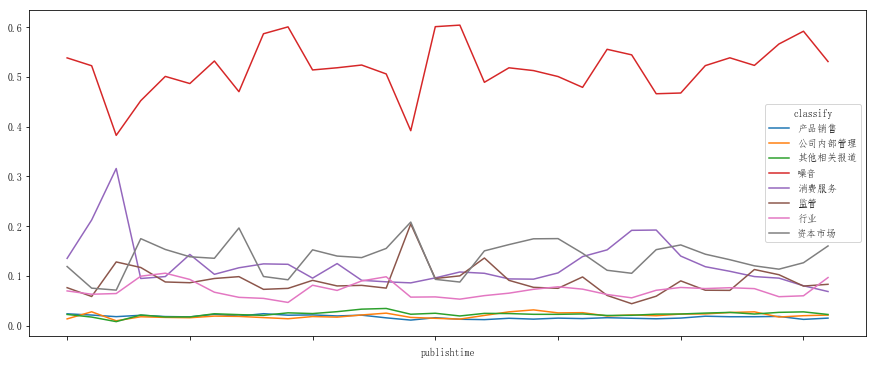

In [39]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

### 总体

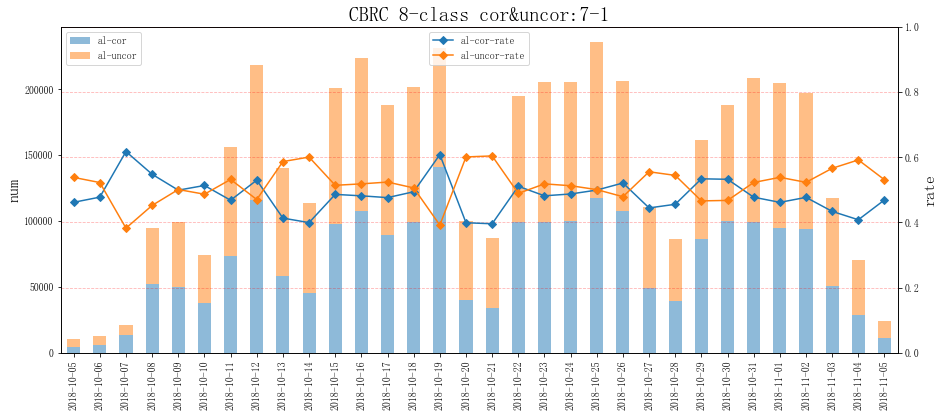

   publishtime     sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
31  2018-11-05   24393   11444     12949        0.469          0.531
30  2018-11-04   70130   28632     41498        0.408          0.592
29  2018-11-03  117268   50886     66382        0.434          0.566
28  2018-11-02  196820   93868    102952        0.477          0.523
27  2018-11-01  204858   94574    110284        0.462          0.538


In [40]:
plot_cor(count_data_7, cbrc_day_thing, "CBRC 8-class cor&uncor:7-1")

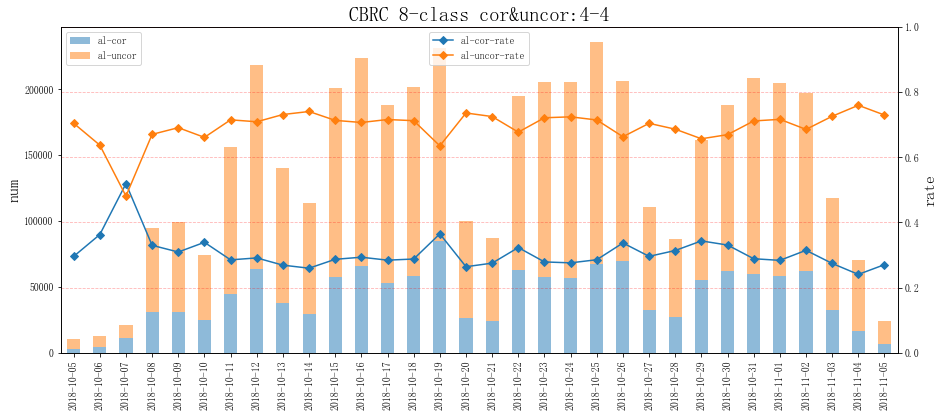

   publishtime  al_cor     sum  al_uncor  al_cor_rate  al_uncor_rate
31  2018-11-05    6602   24393     17791        0.271          0.729
30  2018-11-04   16885   70130     53245        0.241          0.759
29  2018-11-03   32175  117268     85093        0.274          0.726
28  2018-11-02   61923  196820    134897        0.315          0.685
27  2018-11-01   58141  204858    146717        0.284          0.716


In [41]:
plot_cor(count_data_4, cbrc_day_thing, "CBRC 8-class cor&uncor:4-4")

## 倾向性

In [42]:
sql_tend = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.sen as tendency, count(t1.id) as cor_count \
                            from elint_web_docinfo t1 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.sen \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

tend_count = pd.read_sql(sql_tend, engine)
tend_count = tend_count[tend_count['tendency'] != 1]
tend_count.head()

,publishtime,tendency,cor_count
0,2018-11-05,-1,181
1,2018-11-05,0,6508
2,2018-11-04,-1,717
3,2018-11-04,0,16184
5,2018-11-03,-1,2184


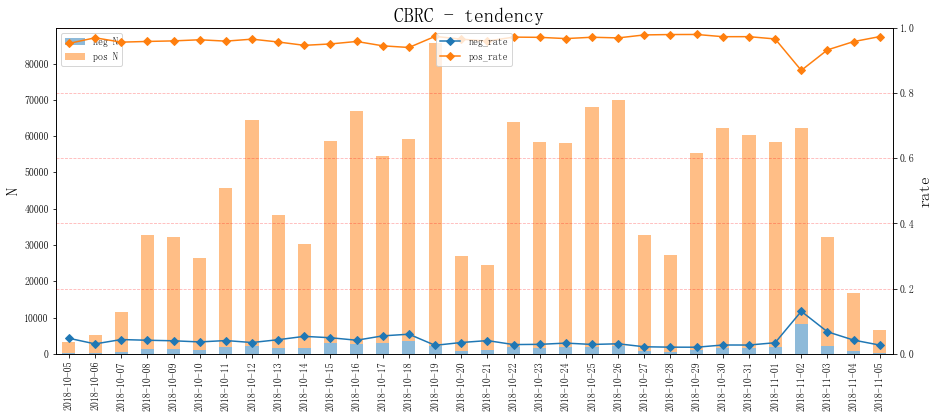

   publishtime   neg    pos    sum  neg_rate  pos_rate
31  2018-11-05   181   6508   6689     0.027     0.973
30  2018-11-04   717  16184  16901     0.042     0.958
29  2018-11-03  2184  29992  32176     0.068     0.932
28  2018-11-02  8144  54197  62341     0.131     0.869
27  2018-11-01  2004  56417  58421     0.034     0.966


In [43]:
plot_tend(tend_count, cbrc_day_thing, "CBRC - tendency ")

## 补录和预警

### 补录数据

In [44]:
sql_human_additional = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, count(t1.id) as count \
                            from elint_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.gather_type = 1 \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d') \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

human_additional_count = pd.read_sql(sql_human_additional, engine)
human_additional_count.sort_values(by = 'publishtime', ascending = False).head()

,publishtime,gather_type,count
0,2018-11-05,1,4
1,2018-11-04,1,1
2,2018-11-03,1,1
3,2018-11-02,1,58
4,2018-11-01,1,56


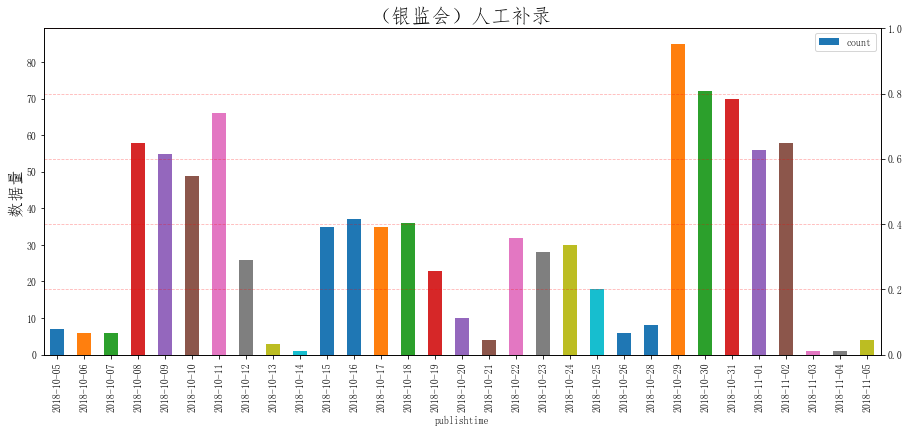

,publishtime,gather_type,count
0,2018-11-05,1,4
1,2018-11-04,1,1
2,2018-11-03,1,1
3,2018-11-02,1,58
4,2018-11-01,1,56


In [45]:
human_additional_count = human_additional_count.sort_values(by = 'publishtime')
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(111)
human_additional_count.plot(x = 'publishtime', y = 'count', kind = 'bar', figsize = (15, 6), ax = ax1)
ax1.set_ylabel('数据量', fontsize = 16)
ax1.set_title("（银监会）人工补录", fontsize = 20)

ax2 = ax1.twinx()  # this is the important function
ax2.set_ylim(0, 1)
y_list = [0.65, 0.75, 0.85, 0.95]
m = 0
for [d, t] in cbrc_day_thing:    
    if d in human_additional_count['publishtime'].tolist():
        x = human_additional_count['publishtime'].tolist().index(d)
        ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                    color='k', linestyle = "--", alpha = 0.75)
        ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
        if m == 3: 
            m = 0
        else :
            m += 1
        
plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
plt.show()

human_additional_count.sort_values(by = 'publishtime', ascending = False).head()

### 一周数据

In [46]:
add_start_day = '2018-10-27'
add_end_day = '2018-11-02'

In [47]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format(add_start_day, add_end_day) 

human_additional = pd.read_sql(sql_human_additional, engine)
print(human_additional.shape)
# human_additional.head()

(349, 7)


In [48]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.sec in (7,8,9) ".format(add_start_day, add_end_day)  

warning = pd.read_sql(sql_warning, engine)
print(warning.shape)
# warning.head()

(590, 7)


In [49]:
combined_data = pd.concat([human_additional, warning])
print('去重前', combined_data.shape)
combined_data = combined_data.drop_duplicates(subset = 'id')
print('去重后', combined_data.shape)

combined_data['group_id'] = combined_data['group_id'].apply(lambda x:group_dict[str(x)])
combined_data['gather_type'] = combined_data['gather_type'].replace(0, '系统采集').replace(1, '人工补录').replace(2, '人工修改')
combined_data['submited'] = combined_data['sec'].apply(lambda x: '预警' if x in [7,8,9] else '不预警')
# combined_data.head()

去重前 (939, 7)
去重后 (591, 7)


In [50]:
combined_data.groupby(['gather_type', 'group_id', 'submited'])['id'].count()

gather_type  group_id  submited
4            微博        预警           42
人工修改         外媒        预警            1
             微信        预警            1
             微博        预警           64
             新闻        预警           50
             新闻客户端     预警            2
             纸媒        预警           73
             论坛        预警            9
人工补录         微信        预警            2
             微博        预警          319
             新闻        不预警           1
                       预警           18
             纸媒        预警            4
             论坛        预警            5
Name: id, dtype: int64

In [51]:
# predict
data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
# url = "http://192.168.0.104:11000/judge_correlation_yjh"
url = "http://47.93.77.19:6001/judge_correlation_yjh"
parse_data = get_server_res_yjh(data, url, 'sec')
# parse_data.head()  

parse_data.columns = ['id', 'predict_label']
parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
parse_data['label'] = ''
parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
parse_data.head()

,id,predict_label,label,cor,all_cor
0,266631913,行业,,1,1
1,266632075,行业,,1,1
2,266676256,噪音,,0,0
3,266683362,消费服务,,1,1
4,266683767,消费服务,,1,1


In [52]:
combined_data = pd.merge(combined_data, parse_data, on  = 'id')
stat = combined_data.groupby(['group_id', 'gather_type', 'submited'])['id'].count().reset_index()

# 补录
stat_a = combined_data.groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a = stat_a[stat_a['gather_type'] == '人工补录']

# 补录且预警
stat_a_w = combined_data[combined_data['submited'] == '预警'].groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a_w = stat_a_w[stat_a_w['gather_type'] == '人工补录']

# 预警
stat_w = combined_data.groupby(['group_id', 'submited'])['id'].count().reset_index()
stat_w = stat_w[stat_w['submited'] == '预警']

# 补录-过算法
stat_a_cor = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_cor = stat_a_cor[stat_a_cor['cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_w_cor = stat_a_w_cor[stat_a_w_cor['cor'] == 1]

# 补录-过算法
stat_a_cor_7 = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_cor_7 = stat_a_cor_7[stat_a_cor_7['all_cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor_7 = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_w_cor_7 = stat_a_w_cor_7[stat_a_w_cor_7['all_cor'] == 1]

In [53]:
stat_a = stat_a[['group_id', 'id']]
stat_a.columns = ['来源', '补录']
stat_a_w = stat_a_w[['group_id', 'id']]
stat_a_w.columns = ['来源', '补录且预警']
stat_w = stat_w[['group_id', 'id']]
stat_w.columns = ['来源', '预警数量']
stat_a_cor = stat_a_cor[['group_id', 'id']]
stat_a_cor.columns = ['来源', '补录&过算法(4类)']
stat_a_w_cor = stat_a_w_cor[['group_id', 'id']]
stat_a_w_cor.columns = ['来源', '补录且预警&过算法(4类)']
stat_a_cor_7 = stat_a_cor_7[['group_id', 'id']]
stat_a_cor_7.columns = ['来源', '补录&过算法(7类)']
stat_a_w_cor_7 = stat_a_w_cor_7[['group_id', 'id']]
stat_a_w_cor_7.columns = ['来源', '补录且预警&过算法(7类)']

In [54]:
stat

,group_id,gather_type,submited,id
0,外媒,人工修改,预警,1
1,微信,人工修改,预警,1
2,微信,人工补录,预警,2
3,微博,4,预警,42
4,微博,人工修改,预警,64
5,微博,人工补录,预警,319
6,新闻,人工修改,预警,50
7,新闻,人工补录,不预警,1
8,新闻,人工补录,预警,18
9,新闻客户端,人工修改,预警,2


In [55]:
stat = pd.merge(stat_a, stat_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_cor, on = '来源')
stat = pd.merge(stat, stat_a_w_cor, on = '来源')
stat = pd.merge(stat, stat_a_cor_7, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w_cor_7, on = '来源', how = 'outer')
stat = stat.set_index('来源').stack().unstack(0)
stat = stat.fillna(0)
stat['总量'] =  stat.sum(axis = 1)
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警'] / stat.loc['预警数量'] 
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警 / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警'] / stat.loc['补录'] 
# stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警 / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类)'] / stat.loc['补录'] 
# stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类)'] / stat.loc['预警数量'] 
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类) / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类)'] / stat.loc['补录'] 
# stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类)'] / stat.loc['补录且预警'] 
# stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.index.name = '保监会：{0} 到 {1}'.format(add_start_day, add_end_day)
stat.fillna(0)

来源,微信,微博,新闻,纸媒,论坛,总量
保监会：2018-10-27 到 2018-11-02,,,,,,
补录,2.000,319.000,19.000,4.000,5.000,349.000
预警数量,3.000,425.000,68.000,77.000,14.000,587.000
补录且预警,2.000,319.000,18.000,4.000,5.000,348.000
补录&过算法(4类),2.000,302.000,12.000,4.000,4.000,324.000
补录且预警&过算法(4类),2.000,302.000,11.000,4.000,4.000,323.000
补录&过算法(7类),2.000,315.000,17.000,4.000,4.000,342.000
补录且预警&过算法(7类),2.000,315.000,16.000,4.000,4.000,341.000
补录且预警 / 预警-比例,67%,75%,26%,5%,36%,59%


### 导出一段时间补录数据用于训练

In [56]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format('2018-08-20', '2018-09-16') 

# human_additional = pd.read_sql(sql_human_additional, engine)
# print(human_additional.shape)
# human_additional.head()

In [57]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.sec in (7,8,9) ".format('2018-08-20', '2018-09-16') 

# warning = pd.read_sql(sql_warning, engine)
# print(warning.shape)
# warning.head()

In [58]:
if 0:
    # url = "http://192.168.0.104:11000/judge_correlation_yjh"
    url = "http://47.93.77.19:6001/judge_correlation_yjh"
    folder = 'cbrc_result_class'
    filename = 'cbrc_add&warning_20180917(0820-0916).xlsx'
    get_period_data_for_training(human_additional, warning, url, folder, filename, 'cbrc')

# 银保监会--新

## 特殊时间点

In [59]:
engine = specific_func.get_engine('cbirc')

In [60]:
cbirc_day_thing = [['2018-05-02', '相关性模型'], 
             ['2018-06-01', '更新相关性模型'], 
             ['2018-06-12', '更新相关性模型'], 
             ['2018-06-12', '上线倾向性模型']
            ]

In [61]:
start_day = today - datetime.timedelta(days=8) # 30 天
start_day = start_day.strftime("%Y-%m-%d") # '2018-08-12'  # 含
end_day = yesterday_str    # 含
print('start_day：',start_day)
print('end_day：',end_day)

start_day： 2018-10-28
end_day： 2018-11-04


## 八分类

In [62]:
sql_cbirc = '''
SELECT 
    DATE_FORMAT(t3.publishtime, '%%Y-%%m-%%d') AS publishtime,
    t2.type,
    t1.traffic_id AS classify,
    COUNT(t1.id) AS count
FROM
    cbrc_circ.db_classify_traffic_docinfo t1
        LEFT JOIN
    cbrc_circ.db_docinfo_trade t2 ON t1.urlhash = t2.urlhash
        LEFT JOIN
    cbrc_circ.db_docinfo t3 ON t2.urlhash = t3.urlhash
WHERE
    date_format(t3.publishtime, '%%Y-%%m-%%d') >= '{0}'
        AND date_format(t3.publishtime, '%%Y-%%m-%%d') <= '{1}'
GROUP BY DATE_FORMAT(t3.publishtime, '%%Y-%%m-%%d') , t2.type , t1.traffic_id
'''.format(start_day, end_day)

cbirc_count = pd.read_sql(sql_cbirc, engine)
cbirc_count['classify'] = cbirc_count['classify'].apply(lambda x:class_name_dict[x])
print(cbirc_count.shape)
print(cbirc_count.info(memory_usage = 'deep'))
cbirc_count.head()

(259, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 4 columns):
publishtime    259 non-null object
type           259 non-null int64
classify       259 non-null object
count          259 non-null int64
dtypes: int64(2), object(2)
memory usage: 46.8 KB
None


,publishtime,type,classify,count
0,2018-10-28,1,监管,858
1,2018-10-28,1,行业,1196
2,2018-10-28,1,产品销售,2819
3,2018-10-28,1,资本市场,2190
4,2018-10-28,1,公司内部管理,1145


In [63]:
print(cbirc_count['count'].sum())
cbirc_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

1335141


sum                                
              count                                
type              1       2      3       4      All
publishtime                                        
2018-10-28    32307   31740   2236    8135    74418
2018-10-29    69033   62087   7303   14854   153277
2018-10-30    97669   79130  10096   21533   208428
2018-10-31   120327  106612  11526   36934   275399
2018-11-01   106211   98361  13326   30381   248279
2018-11-02    97353   87927  11330   26465   223075
2018-11-03    38446   39888   5259   10775    94368
2018-11-04    23197   26831   1557    6312    57897
All          584543  532576  62633  155389  1335141

In [64]:
# sql_1 = '''
# select 
#     t1.urlhash, t1.type, date_format(t2.publishtime,'%%Y-%%m-%%d') as publishtime
# from 
#     db_docinfo_trade t1, db_docinfo t2
# where (date_format(t2.publishtime, '%%Y-%%m-%%d') >= '{0}' and 
#       date_format(t2.publishtime, '%%Y-%%m-%%d') <= '{1}') and
#       t1.urlhash = t2.urlhash'''.format(start_day, end_day) 

# cbirc_count_1 = pd.read_sql(sql_1, engine)
# print(cbirc_count_1.shape)
# print(cbirc_count_1.info(memory_usage = 'deep'))
# cbirc_count_1.head()

In [65]:
# sql_2 = '''
# select 
#     t1.urlhash, t1.traffic_id as classify
# from 
#     db_classify_traffic_docinfo t1, db_docinfo t2
# where (date_format(t2.publishtime, '%%Y-%%m-%%d') >= '{0}' and 
#       date_format(t2.publishtime, '%%Y-%%m-%%d') <= '{1}') and
#       t1.urlhash = t2.urlhash'''.format(start_day, end_day) 

# cbirc_count_2 = pd.read_sql(sql_2, engine)
# print(cbirc_count_2.shape)
# print(cbirc_count_2.info(memory_usage = 'deep'))
# cbirc_count_2.head()

In [66]:
# cbirc_merge = pd.merge(cbirc_count_1, cbirc_count_2, on = 'urlhash', how = 'inner')
# print(cbirc_merge.shape)
# cbirc_merge.head()

In [67]:
# cbirc_merge.pivot_table(index = ['publishtime'], columns = ['type'], 
#                         aggfunc = [len], values = ['urlhash'], 
#                         fill_value = 0, margins = True)

In [68]:
# cbirc_count = cbirc_merge.groupby(['type', 'publishtime', 'classify'])['urlhash'].count().reset_index()
# cbirc_count.columns = ['type', 'publishtime', 'classify', 'count']
# cbirc_count.sort_values(by = 'publishtime', ascending = False).head()

### 银监会

In [69]:
class_count = cbirc_count[cbirc_count['type'] == 1].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                         \
classify        产品销售   公司内部管理   其他相关报道        噪音     消费服务       监管       行业   
publishtime                                                                   
2018-11-04   704.000  912.000  990.000 15037.000  964.000 1616.000 1341.000   
2018-11-03  1328.000  861.000  950.000 26869.000  747.000 3617.000 1613.000   
2018-11-02  3388.000 3065.000 3723.000 62650.000 2093.000 8087.000 5027.000   
2018-11-01  3954.000 3710.000 3831.000 67212.000 2584.000 8614.000 5940.000   
2018-10-31  4347.000 2801.000 3525.000 79312.000 2510.000 9948.000 5991.000   

                                  总量       非噪音 非噪音-比例 噪音-比例  
classify     补录      资本市场                                    
publishtime                                                  
2018-11-04  nan  1633.000  23197.000  8160.000  0.352 0.648  
2018-11-03  nan  2461.000  38446.000 11577.000  0.301 0.699  
2018-11-02  nan  9320.000  97353.000 34703.000  0.356 0.644  
2018-11-01  nan 10366.000 106211.000 38999.000  0.367 0.633  
2018-10-31  nan 11893.000 120327.000 41015.000  0.341 0.659

count                                                         \
classify        产品销售   公司内部管理   其他相关报道        噪音     消费服务       监管       行业   
publishtime                                                                   
2018-11-04   704.000  912.000  990.000 15037.000  964.000 1616.000 1341.000   
2018-11-03  1328.000  861.000  950.000 26869.000  747.000 3617.000 1613.000   
2018-11-02  3388.000 3065.000 3723.000 62650.000 2093.000 8087.000 5027.000   
2018-11-01  3954.000 3710.000 3831.000 67212.000 2584.000 8614.000 5940.000   
2018-10-31  4347.000 2801.000 3525.000 79312.000 2510.000 9948.000 5991.000   

                                  总量  rate                                  \
classify     补录      资本市场             产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管   
publishtime                                                                  
2018-11-04  nan  1633.000  23197.000 0.030  0.039  0.043 0.648 0.042 0.070   
2018-11-03  nan  2461.000  38446.000 0.035  0.022  0.025 0.699 0.019 0.094   
2018-11-02  nan  9320.000  97353.000 0.035  0.031  0.038 0.644 0.021 0.083   
2018-11-01  nan 10366.000 106211.000 0.037  0.035  0.036 0.633 0.024 0.081   
2018-10-31  nan 11893.000 120327.000 0.036  0.023  0.029 0.659 0.021 0.083   

                             
classify       行业  补录  资本市场  
publishtime                  
2018-11-04  0.058 nan 0.070  
2018-11-03  0.042 nan 0.064  
2018-11-02  0.052 nan 0.096  
2018-11-01  0.056 nan 0.098  
2018-10-31  0.050 nan 0.099

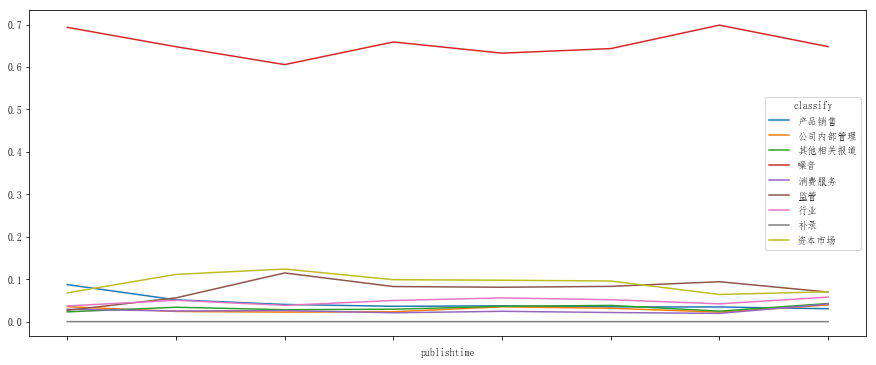

In [70]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

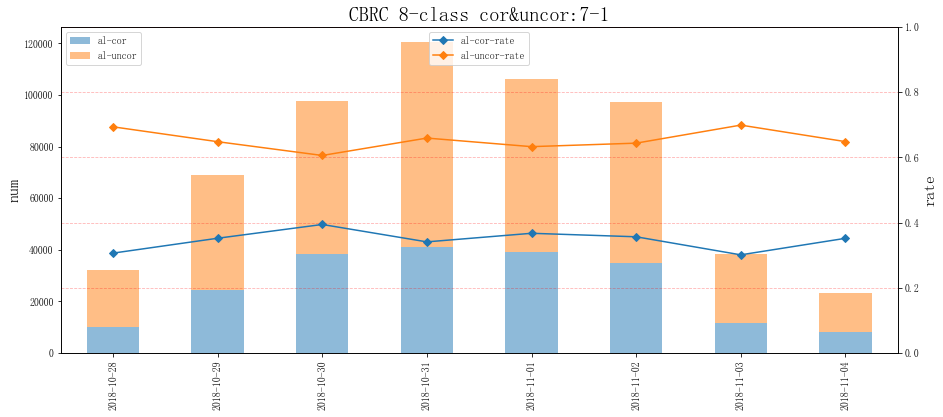

  publishtime        sum    al_cor  al_uncor  al_cor_rate  al_uncor_rate
7  2018-11-04  23197.000  8160.000 15037.000        0.352          0.648
6  2018-11-03  38446.000 11577.000 26869.000        0.301          0.699
5  2018-11-02  97353.000 34703.000 62650.000        0.356          0.644
4  2018-11-01 106211.000 38999.000 67212.000        0.367          0.633
3  2018-10-31 120327.000 41015.000 79312.000        0.341          0.659


In [71]:
plot_cor(count_data_7, cbirc_day_thing, "CBRC 8-class cor&uncor:7-1")

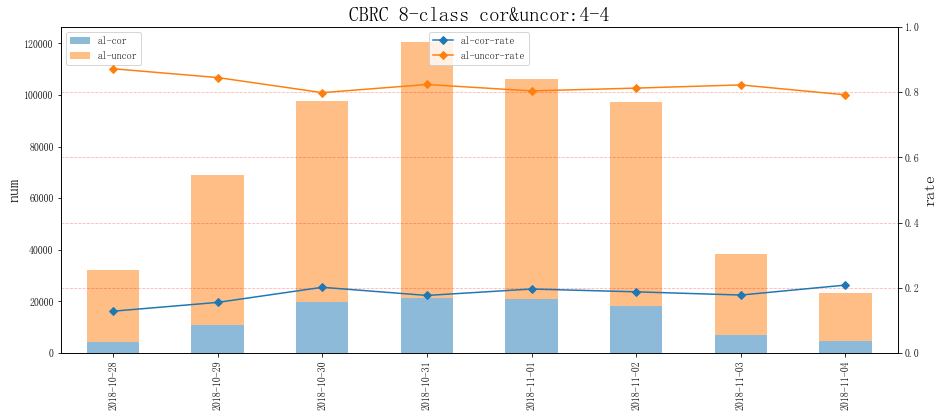

  publishtime    al_cor        sum  al_uncor  al_cor_rate  al_uncor_rate
7  2018-11-04  4833.000  23197.000 18364.000        0.208          0.792
6  2018-11-03  6838.000  38446.000 31608.000        0.178          0.822
5  2018-11-02 18272.000  97353.000 79081.000        0.188          0.812
4  2018-11-01 20848.000 106211.000 85363.000        0.196          0.804
3  2018-10-31 21250.000 120327.000 99077.000        0.177          0.823


In [72]:
plot_cor(count_data_4, cbirc_day_thing, "CBRC 8-class cor&uncor:4-4")

In [73]:
class_count = cbirc_count[cbirc_count['type'] == 1].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                         \
classify        产品销售   公司内部管理   其他相关报道        噪音     消费服务       监管       行业   
publishtime                                                                   
2018-11-04   704.000  912.000  990.000 15037.000  964.000 1616.000 1341.000   
2018-11-03  1328.000  861.000  950.000 26869.000  747.000 3617.000 1613.000   
2018-11-02  3388.000 3065.000 3723.000 62650.000 2093.000 8087.000 5027.000   
2018-11-01  3954.000 3710.000 3831.000 67212.000 2584.000 8614.000 5940.000   
2018-10-31  4347.000 2801.000 3525.000 79312.000 2510.000 9948.000 5991.000   

                                  总量       非噪音 非噪音-比例 噪音-比例  
classify     补录      资本市场                                    
publishtime                                                  
2018-11-04  nan  1633.000  23197.000  8160.000  0.352 0.648  
2018-11-03  nan  2461.000  38446.000 11577.000  0.301 0.699  
2018-11-02  nan  9320.000  97353.000 34703.000  0.356 0.644  
2018-11-01  nan 10366.000 106211.000 38999.000  0.367 0.633  
2018-10-31  nan 11893.000 120327.000 41015.000  0.341 0.659

count                                                         \
classify        产品销售   公司内部管理   其他相关报道        噪音     消费服务       监管       行业   
publishtime                                                                   
2018-11-04   704.000  912.000  990.000 15037.000  964.000 1616.000 1341.000   
2018-11-03  1328.000  861.000  950.000 26869.000  747.000 3617.000 1613.000   
2018-11-02  3388.000 3065.000 3723.000 62650.000 2093.000 8087.000 5027.000   
2018-11-01  3954.000 3710.000 3831.000 67212.000 2584.000 8614.000 5940.000   
2018-10-31  4347.000 2801.000 3525.000 79312.000 2510.000 9948.000 5991.000   

                                  总量  rate                                  \
classify     补录      资本市场             产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管   
publishtime                                                                  
2018-11-04  nan  1633.000  23197.000 0.030  0.039  0.043 0.648 0.042 0.070   
2018-11-03  nan  2461.000  38446.000 0.035  0.022  0.025 0.699 0.019 0.094   
2018-11-02  nan  9320.000  97353.000 0.035  0.031  0.038 0.644 0.021 0.083   
2018-11-01  nan 10366.000 106211.000 0.037  0.035  0.036 0.633 0.024 0.081   
2018-10-31  nan 11893.000 120327.000 0.036  0.023  0.029 0.659 0.021 0.083   

                             
classify       行业  补录  资本市场  
publishtime                  
2018-11-04  0.058 nan 0.070  
2018-11-03  0.042 nan 0.064  
2018-11-02  0.052 nan 0.096  
2018-11-01  0.056 nan 0.098  
2018-10-31  0.050 nan 0.099

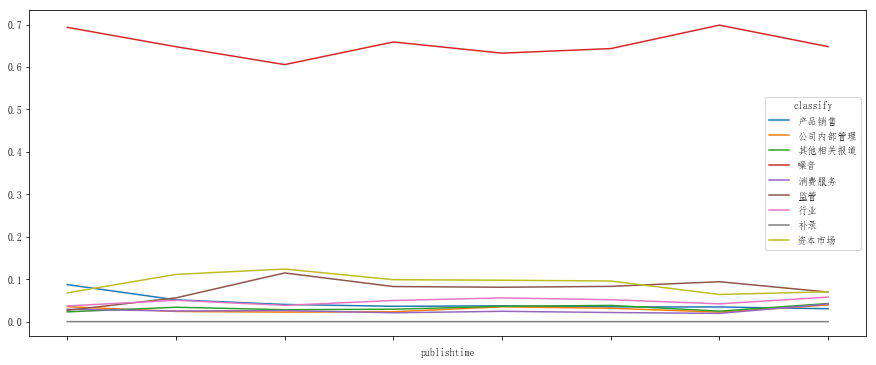

In [74]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

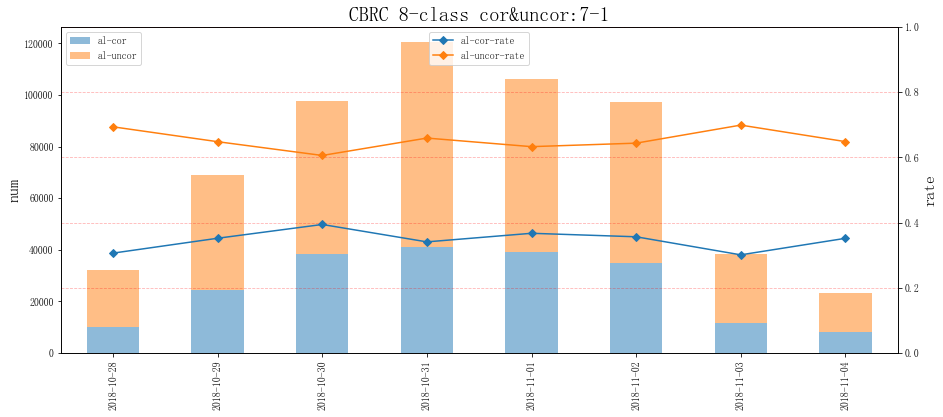

  publishtime        sum    al_cor  al_uncor  al_cor_rate  al_uncor_rate
7  2018-11-04  23197.000  8160.000 15037.000        0.352          0.648
6  2018-11-03  38446.000 11577.000 26869.000        0.301          0.699
5  2018-11-02  97353.000 34703.000 62650.000        0.356          0.644
4  2018-11-01 106211.000 38999.000 67212.000        0.367          0.633
3  2018-10-31 120327.000 41015.000 79312.000        0.341          0.659


In [75]:
plot_cor(count_data_7, cbirc_day_thing, "CBRC 8-class cor&uncor:7-1")

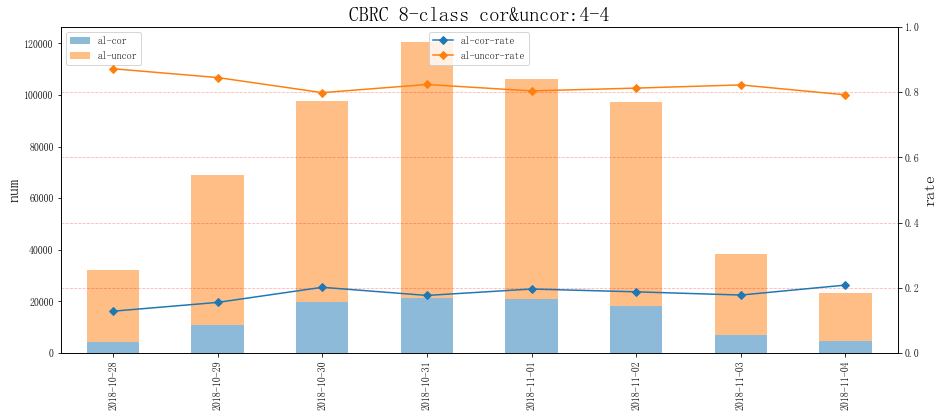

  publishtime    al_cor        sum  al_uncor  al_cor_rate  al_uncor_rate
7  2018-11-04  4833.000  23197.000 18364.000        0.208          0.792
6  2018-11-03  6838.000  38446.000 31608.000        0.178          0.822
5  2018-11-02 18272.000  97353.000 79081.000        0.188          0.812
4  2018-11-01 20848.000 106211.000 85363.000        0.196          0.804
3  2018-10-31 21250.000 120327.000 99077.000        0.177          0.823


In [76]:
plot_cor(count_data_4, cbirc_day_thing, "CBRC 8-class cor&uncor:4-4")

### 保监会

In [77]:
class_count = cbirc_count[cbirc_count['type'] == 2].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                         \
classify        产品销售   公司内部管理   其他相关报道        噪音     消费服务       监管       行业   
publishtime                                                                   
2018-11-04   826.000 1051.000  598.000 19582.000  481.000 2117.000 1088.000   
2018-11-03   941.000  963.000  562.000 30589.000  910.000 3065.000 1438.000   
2018-11-02  1798.000 1460.000 1144.000 64942.000 1859.000 6114.000 3641.000   
2018-11-01  1749.000 1831.000  895.000 72636.000 2304.000 7389.000 5737.000   
2018-10-31  1508.000 1412.000 1051.000 76509.000 1774.000 9727.000 4383.000   

                                  总量       非噪音 非噪音-比例 噪音-比例  
classify     补录      资本市场                                    
publishtime                                                  
2018-11-04  nan  1088.000  26831.000  7249.000  0.270 0.730  
2018-11-03  nan  1420.000  39888.000  9299.000  0.233 0.767  
2018-11-02  nan  6969.000  87927.000 22985.000  0.261 0.739  
2018-11-01  nan  5820.000  98361.000 25725.000  0.262 0.738  
2018-10-31  nan 10248.000 106612.000 30103.000  0.282 0.718

count                                                         \
classify        产品销售   公司内部管理   其他相关报道        噪音     消费服务       监管       行业   
publishtime                                                                   
2018-11-04   826.000 1051.000  598.000 19582.000  481.000 2117.000 1088.000   
2018-11-03   941.000  963.000  562.000 30589.000  910.000 3065.000 1438.000   
2018-11-02  1798.000 1460.000 1144.000 64942.000 1859.000 6114.000 3641.000   
2018-11-01  1749.000 1831.000  895.000 72636.000 2304.000 7389.000 5737.000   
2018-10-31  1508.000 1412.000 1051.000 76509.000 1774.000 9727.000 4383.000   

                                  总量  rate                                  \
classify     补录      资本市场             产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管   
publishtime                                                                  
2018-11-04  nan  1088.000  26831.000 0.031  0.039  0.022 0.730 0.018 0.079   
2018-11-03  nan  1420.000  39888.000 0.024  0.024  0.014 0.767 0.023 0.077   
2018-11-02  nan  6969.000  87927.000 0.020  0.017  0.013 0.739 0.021 0.070   
2018-11-01  nan  5820.000  98361.000 0.018  0.019  0.009 0.738 0.023 0.075   
2018-10-31  nan 10248.000 106612.000 0.014  0.013  0.010 0.718 0.017 0.091   

                             
classify       行业  补录  资本市场  
publishtime                  
2018-11-04  0.041 nan 0.041  
2018-11-03  0.036 nan 0.036  
2018-11-02  0.041 nan 0.079  
2018-11-01  0.058 nan 0.059  
2018-10-31  0.041 nan 0.096

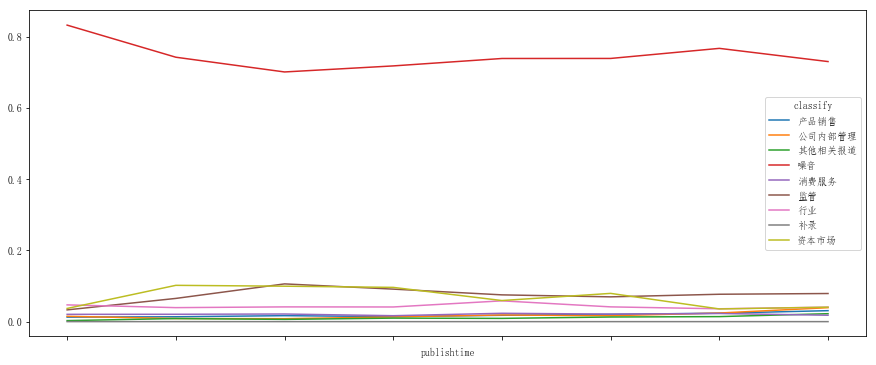

In [78]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

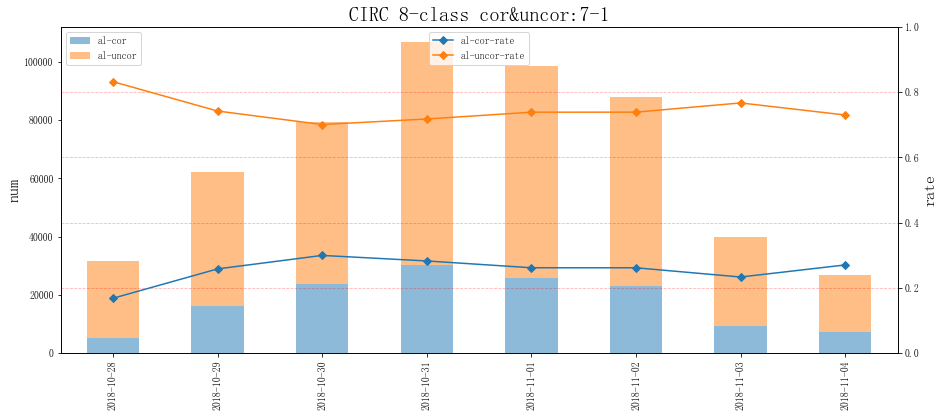

  publishtime        sum    al_cor  al_uncor  al_cor_rate  al_uncor_rate
7  2018-11-04  26831.000  7249.000 19582.000        0.270          0.730
6  2018-11-03  39888.000  9299.000 30589.000        0.233          0.767
5  2018-11-02  87927.000 22985.000 64942.000        0.261          0.739
4  2018-11-01  98361.000 25725.000 72636.000        0.262          0.738
3  2018-10-31 106612.000 30103.000 76509.000        0.282          0.718


In [79]:
plot_cor(count_data_7, cbirc_day_thing, "CIRC 8-class cor&uncor:7-1")

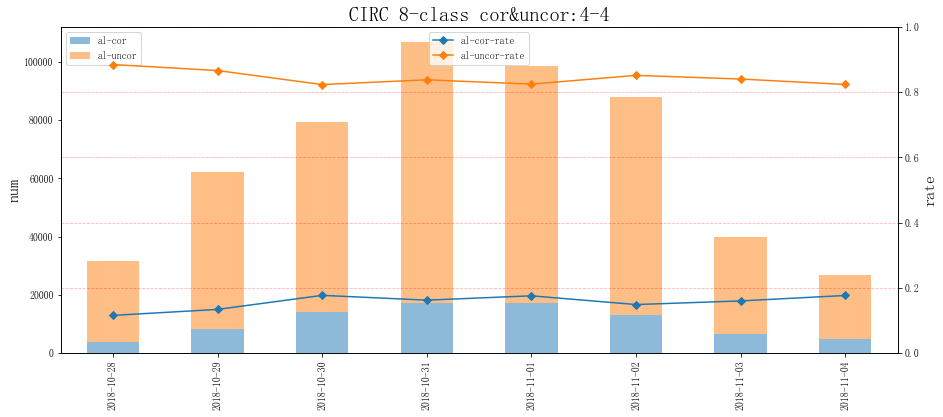

  publishtime    al_cor        sum  al_uncor  al_cor_rate  al_uncor_rate
7  2018-11-04  4737.000  26831.000 22094.000        0.177          0.823
6  2018-11-03  6376.000  39888.000 33512.000        0.160          0.840
5  2018-11-02 13074.000  87927.000 74853.000        0.149          0.851
4  2018-11-01 17261.000  98361.000 81100.000        0.175          0.825
3  2018-10-31 17296.000 106612.000 89316.000        0.162          0.838


In [80]:
plot_cor(count_data_4, cbirc_day_thing, "CIRC 8-class cor&uncor:4-4")

### 中国人寿

In [81]:
class_count = cbirc_count[cbirc_count['type'] == 3].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                总量   非噪音  \
classify     产品销售 公司内部管理 其他相关报道    噪音 消费服务    监管    行业  资本市场                
publishtime                                                                 
2018-11-04     35     41     18   907   95   147   219    95   1557   650   
2018-11-03    189    514    149  3452   17   299   375   264   5259  1807   
2018-11-02    829    190    170  6570  127  1373   777  1294  11330  4760   
2018-11-01    309    324    128  7884  110  1432  1745  1394  13326  5442   
2018-10-31    314    291    190  7458  189   763  1238  1083  11526  4068   

            非噪音-比例 噪音-比例  
classify                  
publishtime               
2018-11-04   0.417 0.583  
2018-11-03   0.344 0.656  
2018-11-02   0.420 0.580  
2018-11-01   0.408 0.592  
2018-10-31   0.353 0.647

count                                                总量  rate  \
classify     产品销售 公司内部管理 其他相关报道    噪音 消费服务    监管    行业  资本市场         产品销售   
publishtime                                                                 
2018-11-04     35     41     18   907   95   147   219    95   1557 0.022   
2018-11-03    189    514    149  3452   17   299   375   264   5259 0.036   
2018-11-02    829    190    170  6570  127  1373   777  1294  11330 0.073   
2018-11-01    309    324    128  7884  110  1432  1745  1394  13326 0.023   
2018-10-31    314    291    190  7458  189   763  1238  1083  11526 0.027   

                                                         
classify    公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                              
2018-11-04   0.026  0.012 0.583 0.061 0.094 0.141 0.061  
2018-11-03   0.098  0.028 0.656 0.003 0.057 0.071 0.050  
2018-11-02   0.017  0.015 0.580 0.011 0.121 0.069 0.114  
2018-11-01   0.024  0.010 0.592 0.008 0.107 0.131 0.105  
2018-10-31   0.025  0.016 0.647 0.016 0.066 0.107 0.094

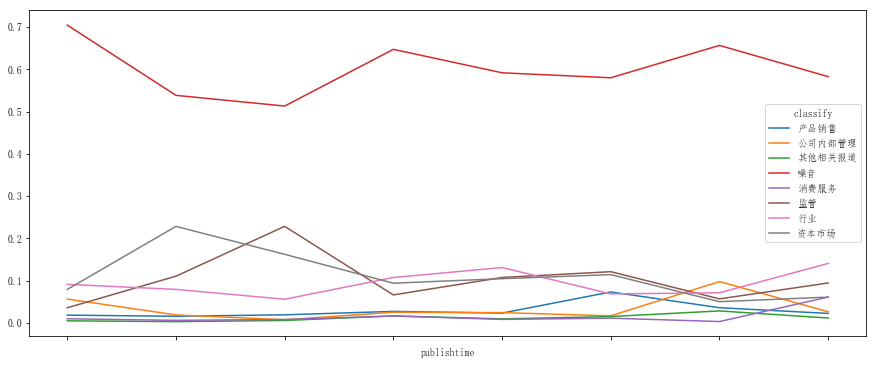

In [82]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

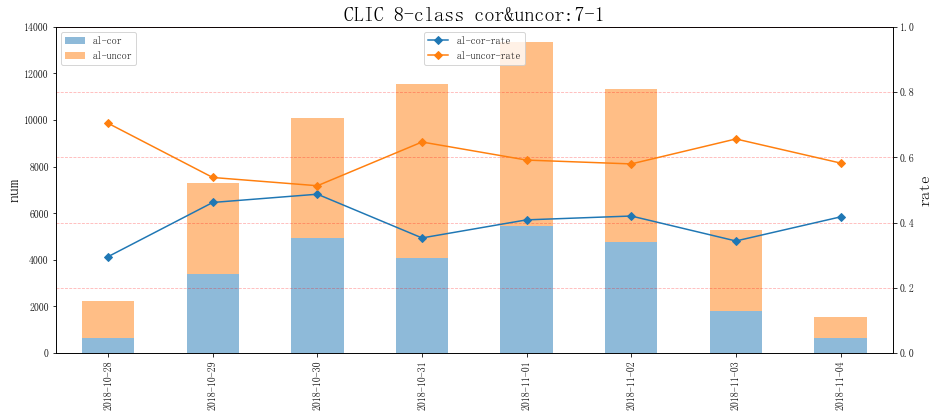

  publishtime    sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
7  2018-11-04   1557     650       907        0.417          0.583
6  2018-11-03   5259    1807      3452        0.344          0.656
5  2018-11-02  11330    4760      6570        0.420          0.580
4  2018-11-01  13326    5442      7884        0.408          0.592
3  2018-10-31  11526    4068      7458        0.353          0.647


In [83]:
plot_cor(count_data_7, cbirc_day_thing, "CLIC 8-class cor&uncor:7-1")

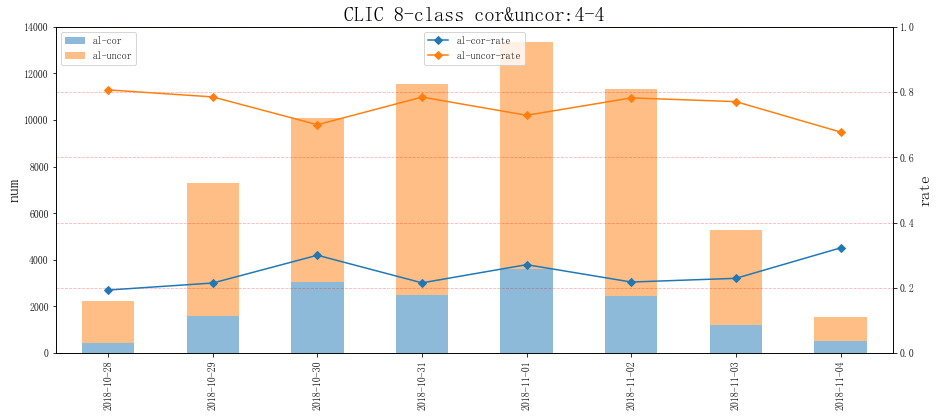

  publishtime  al_cor    sum  al_uncor  al_cor_rate  al_uncor_rate
7  2018-11-04     502   1557      1055        0.322          0.678
6  2018-11-03    1205   5259      4054        0.229          0.771
5  2018-11-02    2467  11330      8863        0.218          0.782
4  2018-11-01    3611  13326      9715        0.271          0.729
3  2018-10-31    2481  11526      9045        0.215          0.785


In [84]:
plot_cor(count_data_4, cbirc_day_thing, "CLIC 8-class cor&uncor:4-4")

### 建行北分

In [85]:
class_count = cbirc_count[cbirc_count['type'] == 4].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                 总量    非噪音  \
classify     产品销售 公司内部管理 其他相关报道     噪音 消费服务    监管    行业  资本市场                 
publishtime                                                                   
2018-11-04     79    196     83   3450  164  1530   242   568   6312   2862   
2018-11-03    416    221    306   7145  202  1353   430   702  10775   3630   
2018-11-02    738   1193    642  15575  455  3758  1268  2836  26465  10890   
2018-11-01   1026   1174    722  15661  536  6777  1579  2906  30381  14720   
2018-10-31    738    660    514  20961  436  8452  2029  3144  36934  15973   

            非噪音-比例 噪音-比例  
classify                  
publishtime               
2018-11-04   0.453 0.547  
2018-11-03   0.337 0.663  
2018-11-02   0.411 0.589  
2018-11-01   0.485 0.515  
2018-10-31   0.432 0.568

count                                                 总量  rate  \
classify     产品销售 公司内部管理 其他相关报道     噪音 消费服务    监管    行业  资本市场         产品销售   
publishtime                                                                  
2018-11-04     79    196     83   3450  164  1530   242   568   6312 0.013   
2018-11-03    416    221    306   7145  202  1353   430   702  10775 0.039   
2018-11-02    738   1193    642  15575  455  3758  1268  2836  26465 0.028   
2018-11-01   1026   1174    722  15661  536  6777  1579  2906  30381 0.034   
2018-10-31    738    660    514  20961  436  8452  2029  3144  36934 0.020   

                                                         
classify    公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                              
2018-11-04   0.031  0.013 0.547 0.026 0.242 0.038 0.090  
2018-11-03   0.021  0.028 0.663 0.019 0.126 0.040 0.065  
2018-11-02   0.045  0.024 0.589 0.017 0.142 0.048 0.107  
2018-11-01   0.039  0.024 0.515 0.018 0.223 0.052 0.096  
2018-10-31   0.018  0.014 0.568 0.012 0.229 0.055 0.085

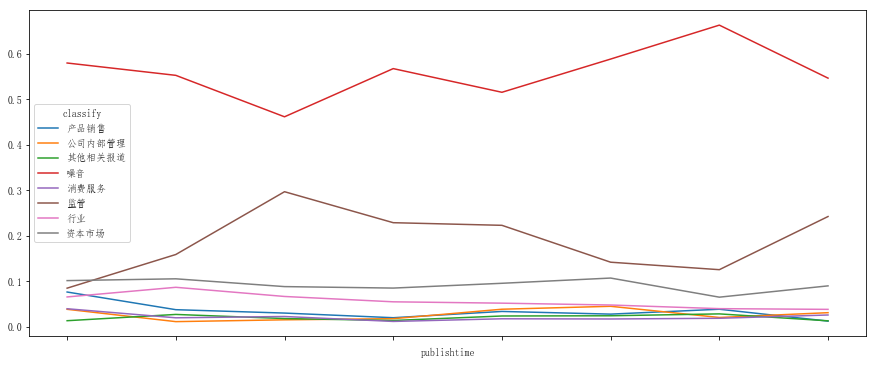

In [86]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

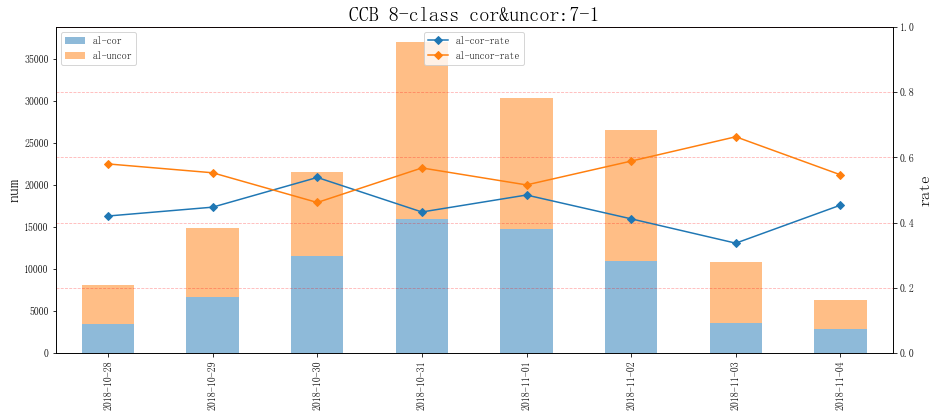

  publishtime    sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
7  2018-11-04   6312    2862      3450        0.453          0.547
6  2018-11-03  10775    3630      7145        0.337          0.663
5  2018-11-02  26465   10890     15575        0.411          0.589
4  2018-11-01  30381   14720     15661        0.485          0.515
3  2018-10-31  36934   15973     20961        0.432          0.568


In [87]:
plot_cor(count_data_7, cbirc_day_thing, "CCB 8-class cor&uncor:7-1")

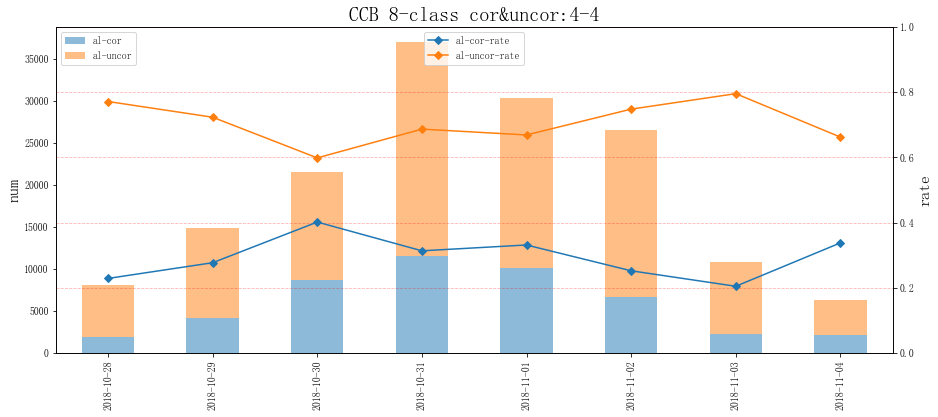

  publishtime  al_cor    sum  al_uncor  al_cor_rate  al_uncor_rate
7  2018-11-04    2132   6312      4180        0.338          0.662
6  2018-11-03    2206  10775      8569        0.205          0.795
5  2018-11-02    6674  26465     19791        0.252          0.748
4  2018-11-01   10066  30381     20315        0.331          0.669
3  2018-10-31   11577  36934     25357        0.313          0.687


In [88]:
plot_cor(count_data_4, cbirc_day_thing, "CCB 8-class cor&uncor:4-4")

## 倾向性

In [89]:
sql_tend = "select date_format(t2.publishtime,'%%Y-%%m-%%d') as publishtime, t1.type, \
                    t1.sen as tendency, count(t1.id) as cor_count \
                            from db_docinfo_trade t1, db_docinfo t2 \
                                where (date_format(t2.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t2.publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.urlhash = t2.urlhash \
                                group by date_format(t2.publishtime,'%%Y-%%m-%%d'), t1.type, t1.sen \
                                order by date_format(t2.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

tend_count = pd.read_sql(sql_tend, engine)
tend_count = tend_count[tend_count['tendency'] != 1]
print(tend_count.shape)
print(tend_count.info(memory_usage = 'deep'))
tend_count.head()

(61, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 0 to 60
Data columns (total 4 columns):
publishtime    61 non-null object
type           61 non-null int64
tendency       61 non-null int64
cor_count      61 non-null int64
dtypes: int64(3), object(1)
memory usage: 5.9 KB
None


,publishtime,type,tendency,cor_count
0,2018-11-04,1,0,26977
1,2018-11-04,2,0,30185
2,2018-11-04,3,0,2449
3,2018-11-04,4,-1,1
4,2018-11-04,4,0,5458


In [90]:
print(tend_count['cor_count'].sum())
tend_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['cor_count'], 
                        fill_value = 0, margins = True)

1184129


sum                                
            cor_count                                
type                1       2      3       4      All
publishtime                                          
2018-10-28      35285   35884   3165    7106    81440
2018-10-29      70439   65436   7407   12394   155676
2018-10-30      92514   78269   8337   16417   195537
2018-10-31      99488   93447   7838   21816   222589
2018-11-01      85444   83636   7688   16610   193378
2018-11-02      82547   78747   7280   16005   184579
2018-11-03      35820   37938   4327    7775    85860
2018-11-04      26977   30185   2449    5459    65070
All            528514  503542  48491  103582  1184129

### 银监会

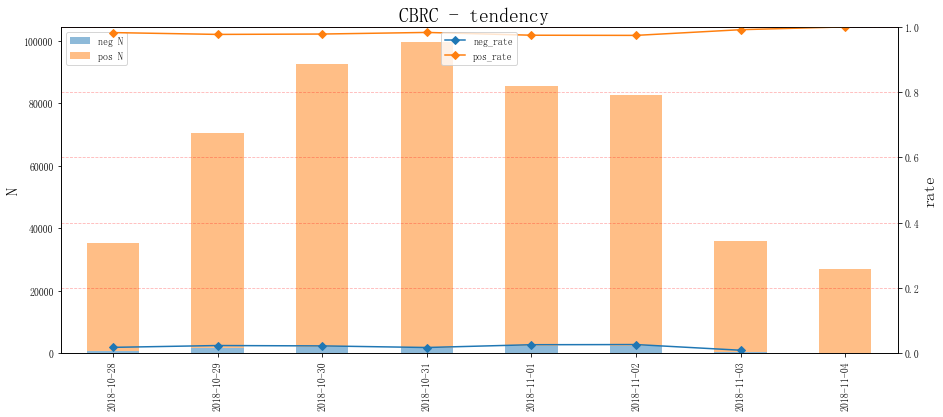

  publishtime      neg       pos       sum  neg_rate  pos_rate
7  2018-11-04      nan 26977.000 26977.000       nan     1.000
6  2018-11-03  308.000 35512.000 35820.000     0.009     0.991
5  2018-11-02 2150.000 80397.000 82547.000     0.026     0.974
4  2018-11-01 2182.000 83262.000 85444.000     0.026     0.974
3  2018-10-31 1690.000 97798.000 99488.000     0.017     0.983


In [91]:
plot_tend(tend_count[tend_count['type'] == 1].drop('type', axis = 1), cbirc_day_thing, "CBRC - tendency ")

### 保监会

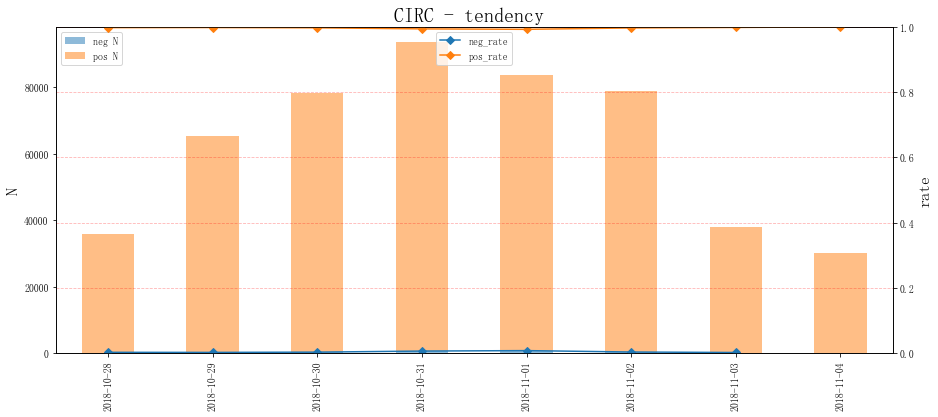

  publishtime     neg       pos       sum  neg_rate  pos_rate
7  2018-11-04     nan 30185.000 30185.000       nan     1.000
6  2018-11-03  64.000 37874.000 37938.000     0.002     0.998
5  2018-11-02 251.000 78496.000 78747.000     0.003     0.997
4  2018-11-01 626.000 83010.000 83636.000     0.007     0.993
3  2018-10-31 570.000 92877.000 93447.000     0.006     0.994


In [92]:
plot_tend(tend_count[tend_count['type'] == 2].drop('type', axis = 1), cbirc_day_thing, "CIRC - tendency ")

### 中国人寿

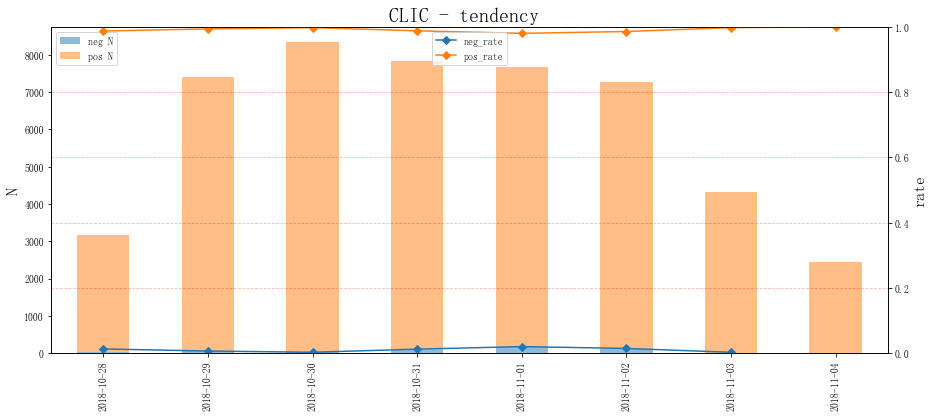

  publishtime     neg      pos      sum  neg_rate  pos_rate
7  2018-11-04     nan 2449.000 2449.000       nan     1.000
6  2018-11-03  10.000 4317.000 4327.000     0.002     0.998
5  2018-11-02 103.000 7177.000 7280.000     0.014     0.986
4  2018-11-01 152.000 7536.000 7688.000     0.020     0.980
3  2018-10-31  94.000 7744.000 7838.000     0.012     0.988


In [93]:
plot_tend(tend_count[tend_count['type'] == 3].drop('type', axis = 1), cbirc_day_thing, "CLIC - tendency ")

### 建行北分

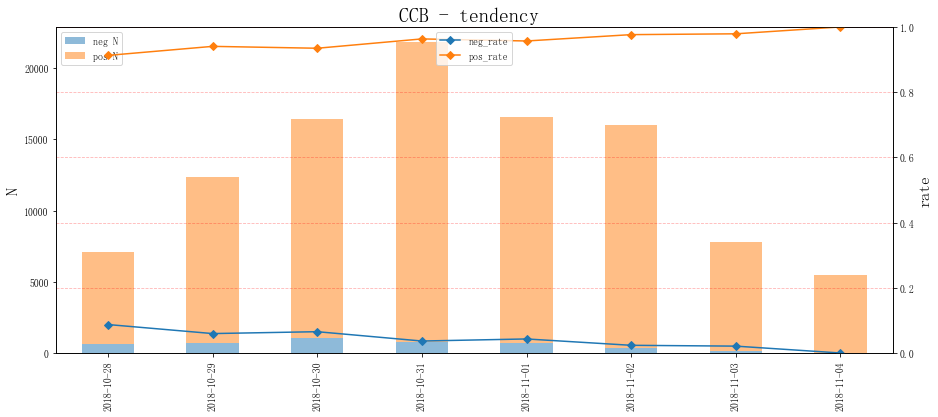

  publishtime  neg    pos    sum  neg_rate  pos_rate
7  2018-11-04    1   5458   5459     0.000     1.000
6  2018-11-03  165   7610   7775     0.021     0.979
5  2018-11-02  380  15625  16005     0.024     0.976
4  2018-11-01  718  15892  16610     0.043     0.957
3  2018-10-31  804  21012  21816     0.037     0.963


In [94]:
plot_tend(tend_count[tend_count['type'] == 4].drop('type', axis = 1), cbirc_day_thing, "CCB - tendency ")

## 补录和预警